In [296]:
import numpy as np
import pandas as pd
from functools import partial, reduce
import sklearn
from random import choice

In [411]:
from folktables import ACSDataSource, ACSEmployment, ACSPublicCoverage
data_source = ACSDataSource(survey_year=2018, horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=['NY'], download=True)
X, y, group = ACSPublicCoverage.df_to_numpy(acs_data)

columns = [
            'AGEP',
            'SCHL',
            'MAR',
            'SEX',
            'DIS',
            'ESP',
            'CIT',
            'MIG',
            'MIL',
            'ANC',
            'NATIVITY',
            'DEAR',
            'DEYE',
            'DREM',
            'PINCP',
            'ESR',
            'ST',
            'FER',
            'RAC1P',
        ]
X = pd.DataFrame(X, columns=columns)
X_ = X.to_numpy()

In [209]:
# Generate a hashmap from group -> dist. of values in group
def generate_comp_table(x):
    grp_list = columns
    x = x.filter(items=grp_list)
    mapping = {}
    for item in x.columns:
        mapping[item] = x[item].value_counts() / len(x[item])
    return mapping

mapping = generate_comp_table(X)

# Group Finder and Disjoint-ify

In [356]:

def G_(model, x, y, n):
    preds = np.array(model.predict(x).round(), dtype='int64')
    y = np.array(y, dtype='int64')
    wrong = y ^ preds
    wrong_idx = np.nonzero(wrong)

    dataset = x.loc[wrong_idx]
    filt = dataset.filter(items=columns)
    size = len(filt)
    op = []
    for col in filt.columns:
        dist = filt[col].value_counts() / size
        rdist = mapping[col][dist.index]
        rdist = (rdist) / rdist.sum()

        # Compare real distribution and distribution in wrongly classified part 

        diff = dist - rdist

        if not len(diff):
            continue
        argmax = diff.idxmax()

        if 500 <= dist.loc[argmax] * size <= (0.6 * size):
            # Conditional checks to ensure that we don't look at majority or significant minority groups
            op.append([col, argmax, max(diff)])
    top_n = sorted(op, key=lambda x: x[2], reverse=True)[:n]
    return [np.where(x[col] == argmax) for col, argmax, _ in top_n], [(col, argmax) for col, argmax, _ in top_n]

def remove_intersect(l):
    n = len(l)
    output = [None for _ in range(n)]
    for i in range(n):
        output[i] = np.setdiff1d(l[i], l[i+1]) if i < n-1 else l[i]
        for j in range(i+2, n):
            output[i] = np.setdiff1d(output[i], l[j])

    assert len(reduce(np.union1d, l)) == len(reduce(np.union1d, output))
    return output


# Models and Helper Functions

In [416]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss

def LinReg(X, y, wts):
    reg = LinearRegression()
    reg.fit(X, y, sample_weight=wts)
    return reg

def GBT(X, y, wts):
    reg = GradientBoostingClassifier(max_depth=3)
    reg.fit(X, y, sample_weight=wts)
    return reg

def LogReg(X, y, wts):
    reg = LogisticRegression()
    reg.fit(X, y, sample_weight=wts)
    return reg

def filter_grp(x, y, g_):
    return x[g_], y[g_]

def eps_k(h, L, x_k, y_k, round=False):
    return L(y_k, h.predict(x_k) if not round else h.predict_(x_k).round())

def eps_k_rand(H, L, x_k, y_k, round=False):
    N = len(y_k)
    models = [choice(H) for _ in range(N)]
    preds = [
        (
            models[i].predict(x_k[i].reshape(1, -1))
            if not round
            else models[i].predict(x_k[i].reshape(1, -1)).round()
        ).item()
        for i in range(N)
    ]
    return L(y_k, preds)

def weights_updater(lr, err, old_wts, g_):
    old_wts[g_] = old_wts[g_] * np.exp(lr * err)
    return old_wts

def test(H, X, y, G, L, eps):
    K = len(G)
    errs = [None for _ in range(K)]
    for k in range(K):
        err = eps(H, L, *filter_grp(X, y, G[k]))
        errs[k] = err
    return errs

# Group Finding for Specific Models

In [417]:
model = GBT(X_, y, None)
G, groups = G_(model, X, y, 5)
G = remove_intersect(G)

# Minimax Fairness Algorithm (MinimaxFair)

In [418]:

# Number of iterations
T = 400
L = log_loss

def MinimaxFair(X, y, G, L, T, H_, lr=None):
    H = [None for _ in range(T)]
    N = len(y)
    K = len(G)
    weights = np.ones(N) / N
    overall_errs = []

    for t in range(1, T+1):
        lr = 1 / np.sqrt(t)
        h_t = H_(X, y, weights)
        H[t-1] = h_t
        errs = [None for _ in range(K)]
        for k in range(K):
            err = eps_k(h_t, sklearn.metrics.zero_one_loss, *filter_grp(X, y, G[k]))
            weights = weights_updater(lr, err, weights, G[k])
            errs[k] = err
        overall_errs.append(errs)
        if (t-1) % 10 == 0:
            print(f"Iteration {t-1}")
    return H, overall_errs

# All Experiments Below

In [ ]:
H_bar, errs = MinimaxFair(X_, y, G, L, T, LinReg)

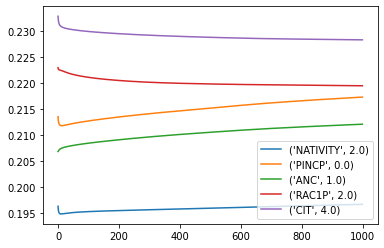

In [318]:
import matplotlib.pyplot as plt
plt.plot(np.array(errs))
plt.legend([('NATIVITY', 2.0), ('PINCP', 0.0), ('ANC', 1.0), ('RAC1P', 2.0), ('CIT', 4.0)])

In [419]:
H_bar_2, errs_2 = MinimaxFair(X_, y, G, L, T, GBT)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290
Iteration 300
Iteration 310
Iteration 320
Iteration 330
Iteration 340
Iteration 350
Iteration 360
Iteration 370
Iteration 380
Iteration 390


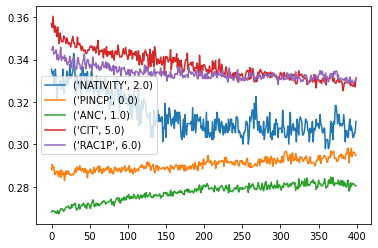

In [420]:
plt.plot(np.array(errs_2))
plt.legend(groups)

In [360]:
import warnings
warnings.filterwarnings("ignore")
H_bar_3, errs_3 = MinimaxFair(X_, y, G, L, T, LogReg)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290
Iteration 300
Iteration 310
Iteration 320
Iteration 330
Iteration 340
Iteration 350
Iteration 360
Iteration 370
Iteration 380
Iteration 390
Iteration 400
Iteration 410
Iteration 420
Iteration 430
Iteration 440
Iteration 450
Iteration 460
Iteration 470
Iteration 480
Iteration 490
Iteration 500
Iteration 510
Iteration 520
Iteration 530
Iteration 540
Iteration 550
Iteration 560
Iteration 570
Iteration 580
Iteration 590
Iteration 600
Iteration 610
Iteration 620
Iteration 630
Iteration 640
Iteration 650
Iteration 660
Iteration 670
Iteration 680
Iteration 690
Iteration 700
Iteration 710
Ite

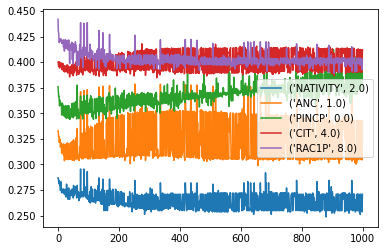

In [361]:
plt.plot(np.array(errs_3))
plt.legend(groups)

In [395]:
g1, g_1 = G_(LinReg(X_, y, None), X, y, 5)
g2, g_2 = G_(LogReg(X_, y, None), X, y, 5)

f = lambda x: str(x[0]) + ": " + str(x[1])

g_1 = list(map(f, g_1))
g_2 = list(map(f, g_2))
g1 = remove_intersect(g1)
g2 = remove_intersect(g2)


errors = test(H_bar, X_, y, g1, sklearn.metrics.zero_one_loss, partial(eps_k_rand, round=True))
errors2 = test(H_bar_3, X_, y, g2, sklearn.metrics.zero_one_loss, partial(eps_k_rand, round=False))

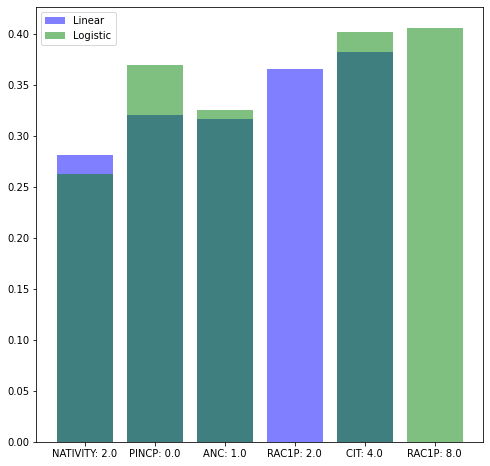

In [406]:
plt.figure(figsize = (8, 8))
plt.bar(g_1, errors, alpha=0.5, color='blue')
plt.bar(g_2, errors2, alpha=0.5, color='green')
plt.legend(['Linear', "Logistic"])